# Aufgabe 1 - Implementierung: Gauß-Sampling

In dieser Datei wird das Gauß-Sampling implementiert <br><br>
Das Gauß-Sampling wird typischerweise für das Mulit-Query-PRM eingesetzt um besser einen Lösungspfad zu finden. <br>
Das Gauß-Sampling gehört zu den **Obstacle-Based-Sampling** und hat dadurch folgende Eigenschaften:
* Generierte Punkte und dadurch Pfade liegen nahe an den Hindernissen <br>
--> es kann einfacher bei vielen und komplexen Hindernissen ein Lösungspfad gefunden werden, da an wichtigen Stellen Punkte vorhanden sind. <br>
--> Pfade verlaufen verstärkt um die Kontur der Hindernisse oder berühren diese sogar
* mit vergleichsweise weniger generierten Punkten können bessere Lösungspfade gefunden werden 
* Mit der Gaußverteilung kann das Verhalten der generierten Punkten/ Lösungspfad bestimmt werden

<img src="img-ip-5-0/Gauss_Bild1.png" width=250em style="float: mid;" />
<img src="img-ip-5-0/Gauss_Bild2.png" width=250em style="float: mid;" />

### Grundidee des Verfahrends für Gauß-Sampling
In einer Schleife werden folgende Schritte durchgeführt um einen Punkt nach dem Gauß-Sampling zu generieren:<br>
Loop:
* Einen zufälligen Punkt im C-Space generieren
* Einen zweiten zufälligen Punkt im C-Space genrieren. Dieser hat jedoch einen bestimmten Abstand d zum ersten Punkt
* **Bedingung**: Ist genau einer der beiden Punkte nicht in Kollision, wird der kollisionsfreie Punkt in die Roadmap hinzugefügt -> Schleife bricht ab

Loop mit negativen Ausgang -> Loop wird wiederholt:<br>
<img src="img-ip-5-0/Verfahren_Gauss1.png" width=200em style="float: mid;" /> <img src="img-ip-5-0/Verfahren_Gauss2.png" width=200em style="float: mid;" /><br clear="left">
Loop mit erfolgreichen Ausgang:<br>
<img src="img-ip-5-0/Verfahren_Gauss1.png" width=200em style="float: mid;" /> <img src="img-ip-5-0/Verfahren_Gauss3.png" width=200em style="float: mid;" />

### Gauß-Verteilung: Bestimmung des Abstands d
Der Abstand d vom zweiten generierten Punkt zum Ersten wird zufällig mithilfe der Gaußverteilung bestimmt. <br>
Hierbei gibt es folgende Paramenter:
* **Mittelwert (Mean)**: Ist der "Hauptabstand" der am häufigsten genommen werden soll
* **Standardabweichung (sigma)**: Gibt an wie oft und weit der Abstand d vom Hauptabstand abweichen soll 

In diesem Bild sieht man die Auswirkung der Standardabweichung mit kleinem Wert bis großen Wert:<br>
<img src="img-ip-5-0/GaussN1.png" width=250em style="float: mid;" /> <img src="img-ip-5-0/GaussN2.png" width=250em style="float: mid;" /><img src="img-ip-5-0/GaussN3.png" width=250em style="float: mid;" /><br clear="mid">



### Einbinden aller erforderlichen Bibliotheken und Files 

In [34]:
import matplotlib.pyplot as plt 
%matplotlib inline

import networkx as nx  # Library for hanling graphs (please check 4_Introduction_Graph)
import random # possibility to create random numbers (The "P" in PRM)
import numpy as np
import math


from IPPerfMonitor import IPPerfMonitor
# sort nearest neighbour brute force
import heapq
import copy

# reduce coding effort by using function provided by scipy
from scipy.spatial.distance import euclidean


#imports for Benchmarks
import importlib # usfull to relaod Files without the need to restart the kernel 
import IPTestSuite # import the enviroment for our Benchmarks 
dim=2

importlib.reload(IPTestSuite)

<module 'IPTestSuite' from 'c:\\Users\\jonas\\Documents\\08_Master\\Python_Projekte\\Roboter_Programmierung\\Roboterprogrammierung_Projektarbeit\\IPTestSuite.py'>

### Gauß Funktion in Python
Über die Funktio np.random.normal(mean,sigma,n) kann eine Gauß Funktion um den Mittelwert mean mit der Standardabweichung sigma erzeugt werden. 
Über die Variable n wird angegeben wie viele Random Werte aus der Gauß Verteilung ausgegben werden sollen. Standardmäßig ist dieser Wert auf eins  

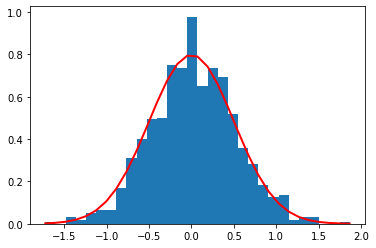

In [35]:
mu,sigma =0,0.5
s=np.random.normal(mu,sigma,1000)


count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()



### "inSameConntectedCoponent" 
 Die Funktion schaut ob die übergebenen Punkte in der selben Komponente liegen

In [36]:
def inSameConnectedComponent(node1, node2, graph):
    """ Check whether to nodes are part of the same connected component using
        functionality from NetworkX
    """
    for connectedComponent in nx.connected_components(graph): 
        if (node1 in connectedComponent) & (node2 in connectedComponent):
            return True
        
    return False

### "nearestNeighboursX" 
 Die Funktion findet zu einem gegebenen Punkt alle Punkte in einem gegebenen Radius und sortiert diese mit aufsteigender Distanz in einen Heap 

In [37]:
def nearestNeighboursX(pos, graph, radius):
    """ Brute Force method to find all nodes of a 
    graph near the given position **pos** with in the distance of
    **radius** in **increasing order**"""
    
    heap = list()
    for node in graph.nodes(data=True): # using (data=True) will generate a list of nodes with all attributes
        if euclidean(node[1]['pos'],pos) < radius:
            # use a heap-queue to sort the nodes in increasing order
            heapq.heappush(heap, (euclidean(node[1]['pos'] ,pos), node))
            #if len(heap) > 2 :
            #    break

    result = list()
    while len(heap) > 0 :
         result.append(heapq.heappop(heap)) 
    
    return result

### "Orignal": Normal Gauß Sampling 

(Vorgang wie Oben beschrieben)


In [38]:
def normal_Gaus_Sampling(collChecker):
    
    # Get the limites for the graph 
    limits = collChecker.getEnvironmentLimits()   
    # Get a random position within the limits    
    pos = [random.uniform(limit[0],limit[1]) for limit in limits]
    # get a distance for the second Point over a gaussian distribution 
    d=np.random.normal(1,0.5) # get a distance d for the second point over a normal gaussian distribution
    pos_x=pos[0]# store the x value
    pos_y=pos[1]# store the y value
    
    # get a random angle between 0 and 360
    alpha=random.uniform(0,360)*(math.pi/180)
    # calculate the new Point with the random angle and the selected distance d 
    pos2_x=d*math.cos(alpha)+pos_x # calculate the x value of pos2
    pos2_y=d*math.sin(alpha)+pos_y# calculate the y valur of pos2 
    # store the Point 
    pos2=[pos2_x,pos2_y]# store pos2


        
    # check if the first Point is in collision and the secon ist collision free 
    if not collChecker.pointInCollision(pos2) and collChecker.pointInCollision(pos):
        return pos2 # return pos2 wich now can be added to the roadmap  
    # check if the second Point is in collision and the first is collision free 
    if not collChecker.pointInCollision(pos) and collChecker.pointInCollision(pos2):
        return pos # return pos wich now can be added to the roadmap  
    #if none of the both above conditions is true return False 
    return False

### Variation 1: simple Gauß Sampling  
   1. finde einen Zufälligen Punkt im Konfigurationsraum und überprüfe diesen auf Kollision 
      * Kollisionsfrei: Punkt wird verworfen und Funktion liefert **False** zurück. 
      * Kollision: Puntk wird zwischengespeichert und X und Y Werte werden erfasst.
   2. Finde einen zweiten Punkt im Konfigurationsraum 
      * Der Abstand **d** zum zweiten Punkt wird zufällig aus einer Gaußschen Normalverteilung gewählt.
      * Wäle einen zufälligen Winkel **alpha** für die Richtung in der nach dem zweiten Punkt geschaut werden soll. 
      * Mittels dem Abstand **d** und dem Winkel **alpha** und trigonometrischen Funktionen werden die X und Y Koordinaten des zweiten Punktes berechnet. 
   3. Überprüfe den gefunden zweiten Punkt auf Kollision
    * Kollision: Punkt wird verworfen und die Funktion liefert **Fallse** zurück. 
    * Kollisionsfrei: Punkt wird zurückgeliefert -->Sampling war erfolgreich.

      
    


In [39]:
def simple_Gaussian_Sampling(collChecker):
    
    
    # Get the limites for the graph 
    limits = collChecker.getEnvironmentLimits()   
    # Get a random position within the limits    
    pos = [random.uniform(limit[0],limit[1]) for limit in limits]
    # If selected Configuration is not free pick the Point 
    if not collChecker.pointInCollision(pos):
        return False 
    # get a distance for the second Point over a gaussian distribution 
    d=np.random.normal(1,1)
    pos_x=pos[0]# store the x value 
    pos_y=pos[1]# store the y value 
    # get a random angle between 0 and 360 
    alpha=random.uniform(0,360)*(math.pi/180)
    # calculate the new Point with the random angle and the selected distance d 
    pos2_x=d*math.cos(alpha)+pos_x # calculate the x value of point 2 
    pos2_y=d*math.sin(alpha)+pos_y # calculate the y value of the point2 
   
    pos2=[pos2_x,pos2_y] #store the Point 
    # check if the Point is collision free 
    if collChecker.pointInCollision(pos2):
        return False
    
    return pos2 # return pos2 wich now can be added to the roadmap  

    

    

### Variation 3: komplexes Gauss Sampling
im Unterschied zu den vorher gezeigten Verfahren wird der erste Punkt solange neu gewählt, bis ein Punkt gefunden wurde der Kollidiert. 
Anschließend wird zu diesem Punkt in einer Schleife ein zweiter Punkt mit einem Abstand d(Gauße Normalverteilung) und varierenden Winkel gesucht. Dadurch, dass zu dem ersten gefunden Punkt ein zweiter, nicht kollidierender Punkt in einer Schleife gesucht wird, werden hier deutlich mehr Kollision Checks benötigt und die Berechnungsdauer dauert länger. Aufgrund Dessen wurden für die Benchmark Versuche die Funktion "Simple_Gaussian_Sampling" verwendet.

In [40]:
def agressiv_Gaussian_sampling(collChecker):
    
    limits = collChecker.getEnvironmentLimits()# Get the limites for the graph 
    pos = [random.uniform(limit[0], limit[1]) for limit in limits]# Get a Random position within the limits 

    # get a colliding point
    for t in range(0, 10):# if no valid configuration with the pos was found pick a new first point(10 times)
        while not collChecker.pointInCollision(pos):# generate a randmom pos until the pos is in collision 
            pos = [random.uniform(limit[0], limit[1]) for limit in limits]

       
        pos_x = pos[0]# store the x value of the point 
        pos_y = pos[1]# store the y value of the point 

        # find a non colliding point in a given distance to point a
        for i in range(0, 50): # check the angles for pos and a distance d if no valid config was found pick an new distance d(50 times)
            d = np.random.normal(1, 1)# get the distance d to the next point over a gaussian normal distribution 
            angle_list = [0, 2*math.pi]# create a angle list with value 0 and two pi
            for n in range(8):
                templist = copy.deepcopy(angle_list)# make a true copy from the angle list
                new_angles_list = []# create a new angle list
                verschoben = 1 #set the var for the shift to one 
                for idx in range(len(templist)-1):
                    new_angle = (templist[idx]+templist[idx+1])/2# create a new angle that is between the two picked angles 
                    new_angles_list.append(new_angle)# append the new angle
                    angle_list.insert(idx+verschoben, new_angle)# insert the new angle in the angle list
                    verschoben += 1 # increase the shift 
                for alpha in new_angles_list: # calculate the pos2 for the angles in the new_angle_list  
                    pos2_x = d*math.cos(alpha)+pos_x # calculate the x position for pos2
                    pos2_y = d*math.sin(alpha)+pos_y # calculate the y position for pos2
                    pos2 = [pos2_x, pos2_y]# store pos2
                    if not collChecker.pointInCollision(pos2):# check if pos2 is not in collision 
                        return pos2 # return pos3 wich now can be added to the roadmap  

    return False # if no valild configuration could be found return False

### "learn_RoadmapNearestNeighbour" 
Die Funktion  erzeugt eine vorgegebene Anzahl an Punkte mit dem Bridge Sampling Verfahren und fügte diese der Roadmap hinzu

In [41]:
def learnRoadmapNearestNeighbour(graph, dim, radius, numNodes, collisionChecker):
    i = 1
    while i < numNodes: # generate new nodes until the desired number has been reached 
      
        pos=False# initalize the pos var 
        num_loops = 0 # set the counter for the count of the loops  to zero 
        while pos==False: # create a new point with the Bridge Sampling until a valid point is returned 
            num_loops += 1# increase the loop counter 
            pos = simple_Gaussian_Sampling(collisionChecker)
            if num_loops > 200:# if the loop counter is over 200 stop the sampling - protect from deadlocks 
                break
        
        # Find set of candidates to connect to sorted by distance
        #result = nearestNeighboursX(pos, graph, radius) # commented out because we dont want the result path for our Benchmarks 
        
        # check connection
        if pos is not False:
            graph.add_node(i, pos=pos)
            
        # commented out because we dont want the result path edges for our Benchmarks 
        """
        for idx, data in enumerate(result):
            if not inSameConnectedComponent(i,data[1][0],graph):
                if not collisionChecker.lineInCollision(pos,data[1][1]['pos']):
                    graph.add_edge(i,data[1][0])
        """           
        i+=1

### "find_Path" 
Die Funktion versucht einen Pfad von der Start zur Ziepose zu finden mit der erzeugten Roadmap 

In [42]:
def findPath(graph, start, goal,collisionChecker):
    # find nearest, collision-free connection between node on graph and start
    result = nearestNeighboursX(start, graph, radius)
    for node in result:
        if not collisionChecker.lineInCollision(start,node[1][1]['pos']):
            graph.add_node("start", pos=start)
            graph.add_edge("start",node[1][0])
            break;
    # find nearest, collision-free connection between node on graph and goal
    result = nearestNeighboursX(goal, graph, radius)
    
    for node in result:
        if not collisionChecker.lineInCollision(goal,node[1][1]['pos']):
            graph.add_node("goal", pos=goal)
            graph.add_edge("goal",node[1][0])
            break;
    # find shortest path on graph
    path = nx.shortest_path(graph,"start","goal")
    # return nodelist
    return path

### "basicPRMVisualize" 
 Die Funktion  visualisiert die Benchmark umgebungen mit deren Hindernissen und der dazu erzeugten Roadmap


In [43]:
def basicPRMVisualize(graph, collChecker, solution, nodeSize=300.0, ax=None):
    # get a list of posiations of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    
    # draw graph (nodes colorized by degree)
    nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    
     # commented out because we only want the nodes and not the edges for our Benchmark 
    """
    nx.draw_networkx_edges(graph,pos,
                                ax = ax
                                )
    """
   
    collChecker.drawObstacles(ax)
    
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=300,
                             node_color='g',  ax = ax)
        
    # draw edges based on solution path
    # commented out because we dont want them in our Benchmark 
    #nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,  ax = ax)
        
    # draw start and goal
    # commented out because we dont want them in our Benchmark 
    """"
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#DD0000', ax = ax)
    """
    

### Importieren der Benchmark Umgebung 

In [44]:

for benchmark in IPTestSuite.benchList:
    print(benchmark.name)



Trap
Bottleneck
Fat bottleneck
Spirals
Entrance
Entrances
KIT
Inside
SSL
Ring
Hemispheres
Hammerhead
Zigzag
Spiral
medium
medium2
L-square
Teeth
Gearshift
Squares_easy
Zigzag_medium
Zigzag_hard
Japan
Haystack
HairPerson
M Sahpe(JM)
Random Field (LB)
stick figure (AA)
Double Circle(JM)
Sun Scribble (FP)
Wpoint (SS)
Points Field (NC)
Hi (TN)
S Field
HKA (SS)
HKA (HKA)
tLines (TK)
U Lines (KA)
Ricos Moderne Kunst
Pillars (MA)
Random Bubbles (MS)
Point Matrix (CH)
VFB (LD)
Face (JS)
Maze (AZ)
Robo (FP)
Stickman (MK)
House (AZ)
2030+ (2030+)
Random Bubbles (MS)


### Erzeugen der Roadmapp für alle geladenen Benchmarks


Planning:  M Sahpe(JM)
pointInCollision- Aufrufe 3292
Failed No path between start and goal.
Planning:  Random Field (LB)


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


pointInCollision- Aufrufe 2667
Failed No path between start and goal.
Planning:  stick figure (AA)
pointInCollision- Aufrufe 4250
Failed Either source start or target goal is not in G
Planning:  Double Circle(JM)
pointInCollision- Aufrufe 3917
Failed Either source start or target goal is not in G
Planning:  Sun Scribble (FP)
pointInCollision- Aufrufe 3531
Failed No path between start and goal.
Planning:  Wpoint (SS)
pointInCollision- Aufrufe 4428
Failed No path between start and goal.
Planning:  Points Field (NC)
pointInCollision- Aufrufe 2371
Failed No path between start and goal.
Planning:  Hi (TN)
pointInCollision- Aufrufe 3172


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


Failed No path between start and goal.
Planning:  S Field
pointInCollision- Aufrufe 2020
Failed No path between start and goal.
Planning:  HKA (SS)
pointInCollision- Aufrufe 4058
Failed No path between start and goal.
Planning:  HKA (HKA)
pointInCollision- Aufrufe 2745
Failed No path between start and goal.
Planning:  tLines (TK)
pointInCollision- Aufrufe 3816
Failed No path between start and goal.
Planning:  U Lines (KA)
pointInCollision- Aufrufe 2774
Failed Either source start or target goal is not in G
Planning:  Ricos Moderne Kunst
pointInCollision- Aufrufe 2777
Failed Either source start or target goal is not in G
Planning:  Pillars (MA)
pointInCollision- Aufrufe 1827
Failed No path between start and goal.


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


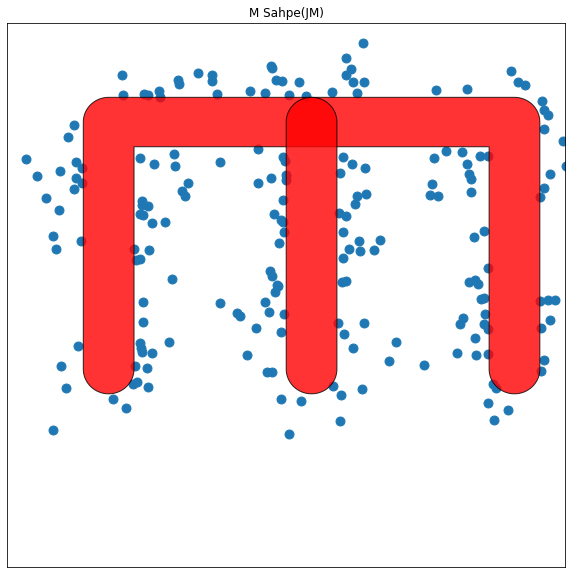

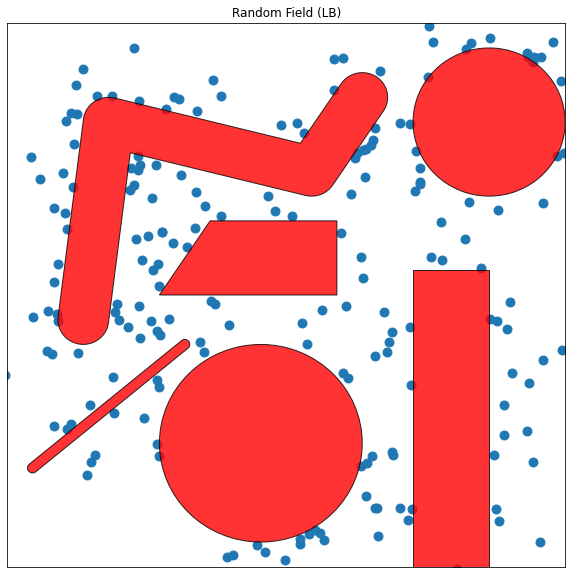

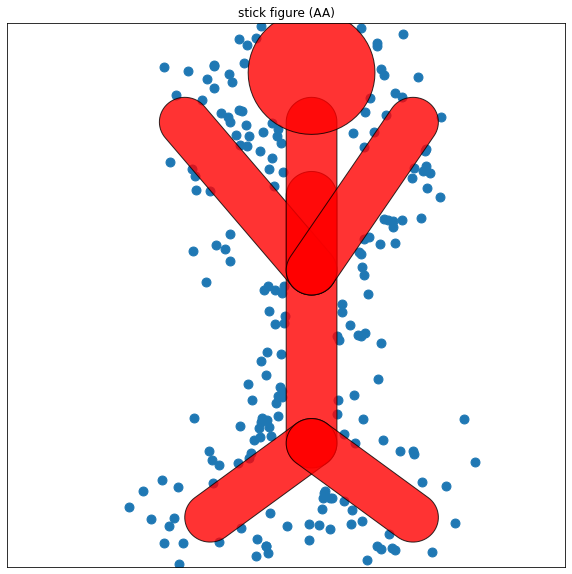

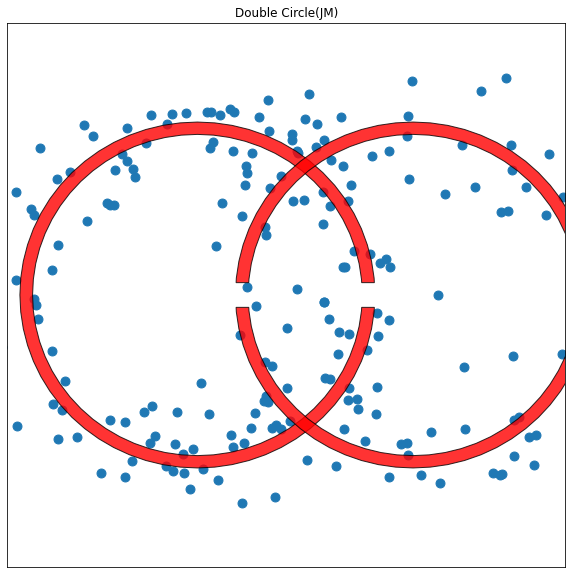

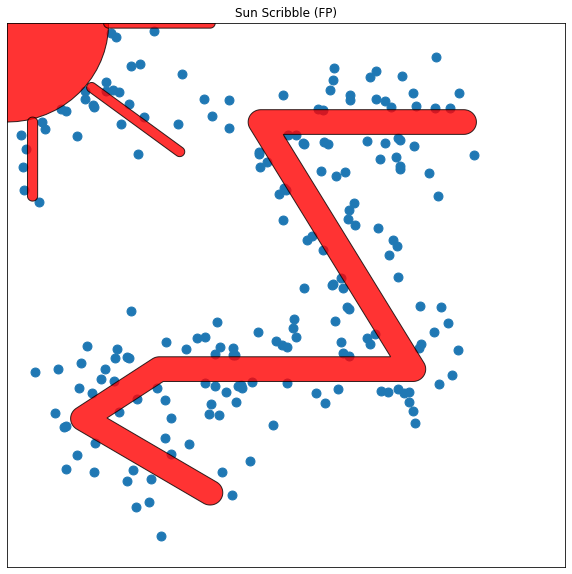

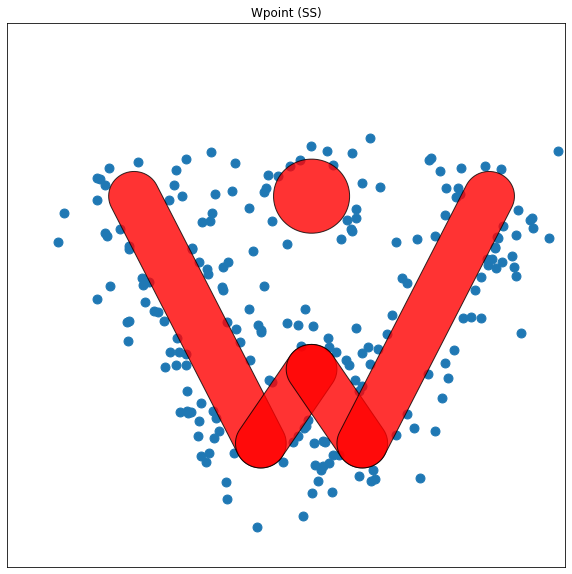

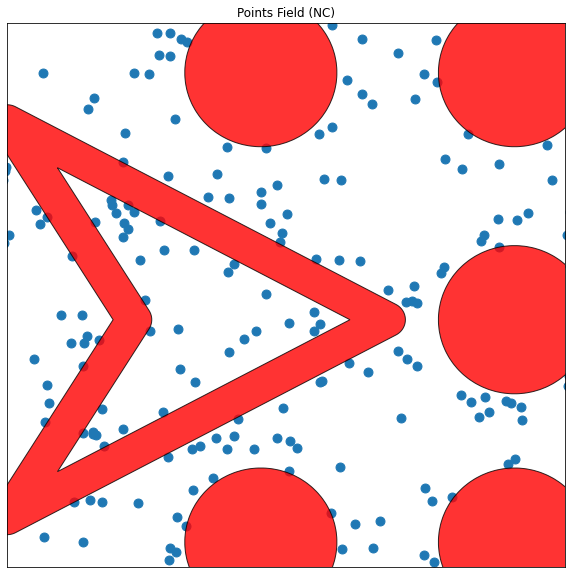

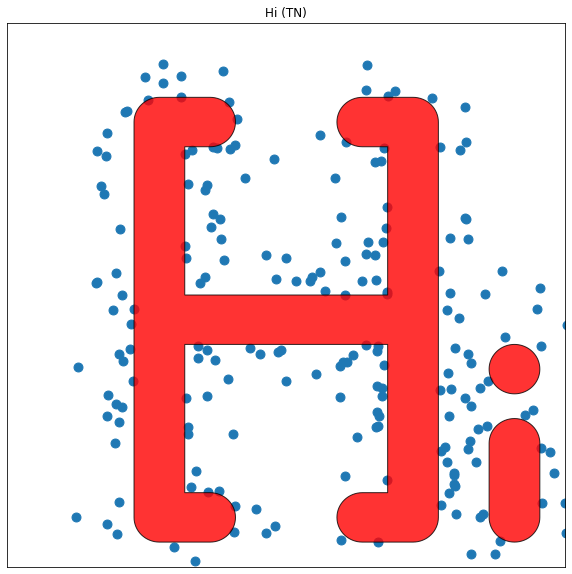

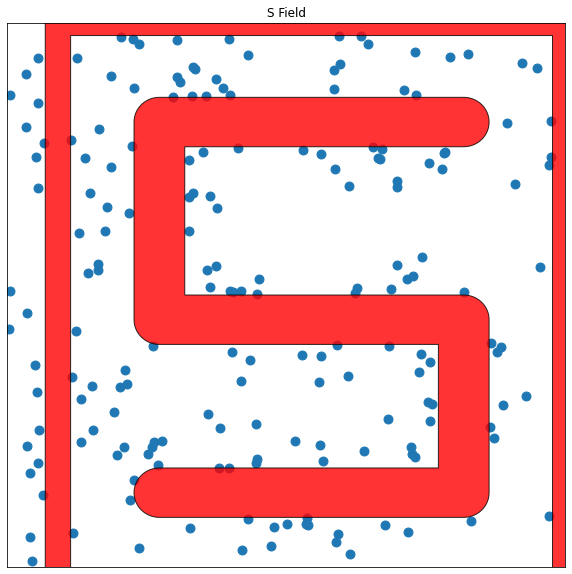

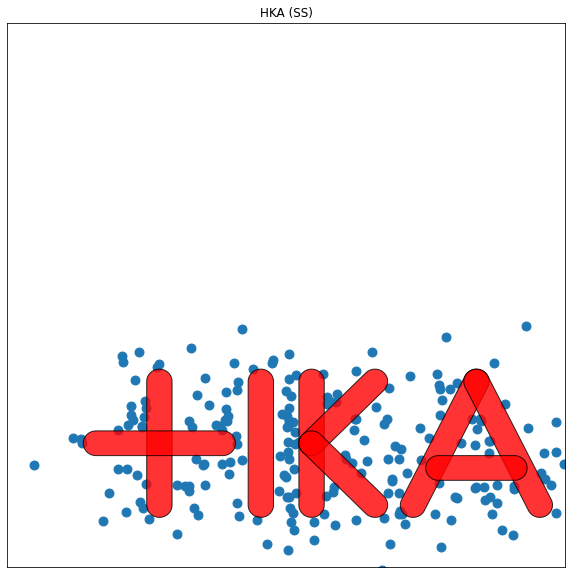

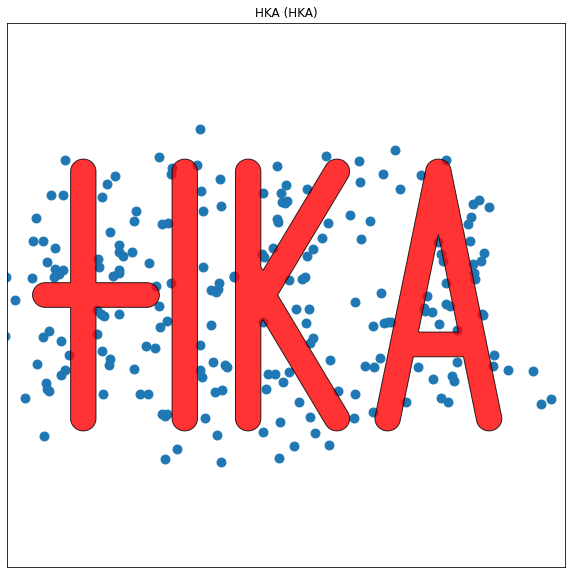

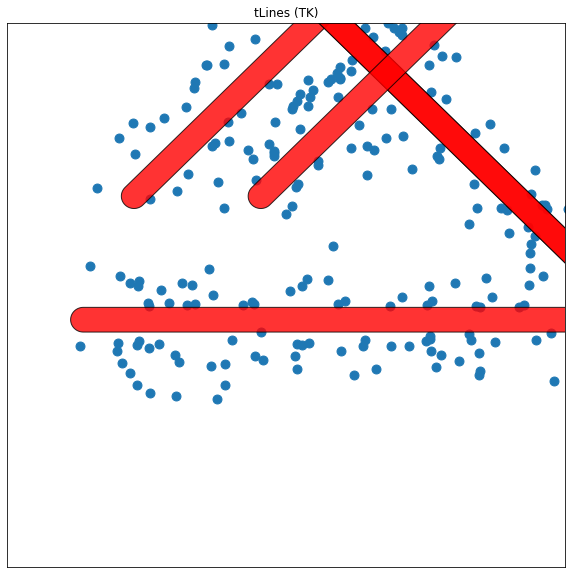

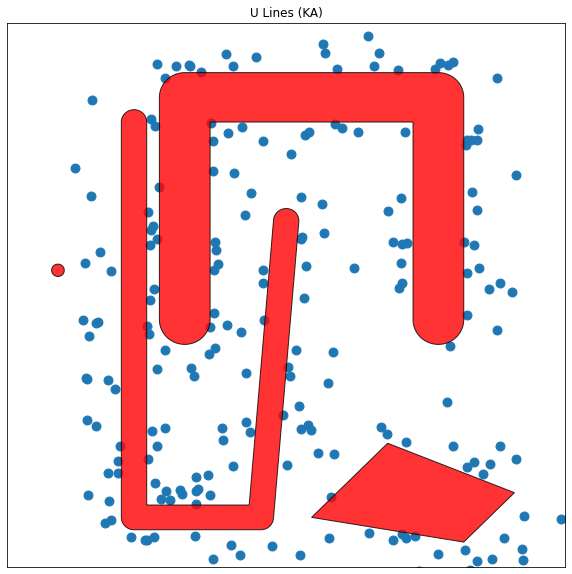

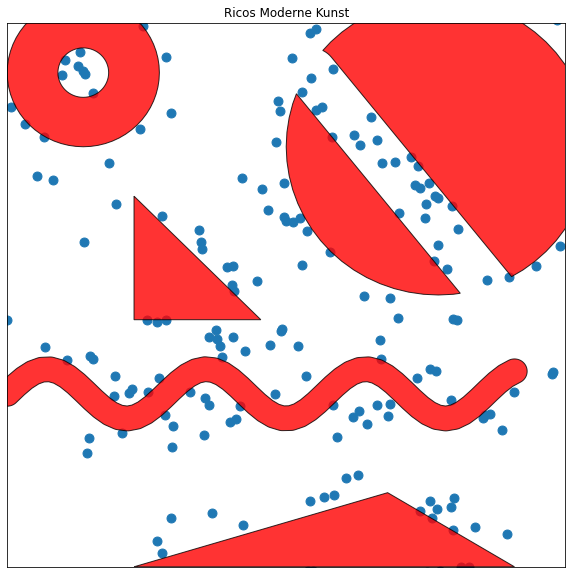

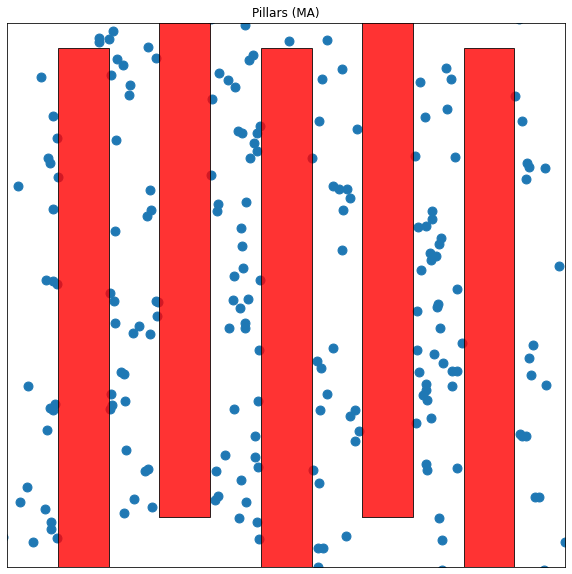

In [45]:
temp_list=IPTestSuite.benchList[25:40]

for benchmark in temp_list:
    try:
        print ("Planning: ", benchmark.name)
        collChecker = benchmark.collisionChecker
        G = nx.Graph()
        radius = 3.0
        numNodes = 200

        IPPerfMonitor.clearData()        
        learnRoadmapNearestNeighbour(G, dim, radius, numNodes, collChecker)

        Function_infos = IPPerfMonitor.dataFrame()
        counts_for_collision = len(Function_infos[Function_infos["name"]=="pointInCollision"])
        print("pointInCollision- Aufrufe", counts_for_collision)

        
        solution = findPath(G,benchmark.startList[0],benchmark.goalList[0], collChecker)
        print(solution, len(solution))
        print(len(G.nodes()))
        
    except Exception as e:
        solution = []
        print ("Failed", e)
    # draw the planning
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    limits=collChecker.getEnvironmentLimits()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_title(benchmark.name)
    basicPRMVisualize(G,collChecker,solution,nodeSize=80,ax=ax)